# Security Beta Estimation and Shrinkage

This project gives alternative ways to look at beta for security analysis, strategy development and hedging purposes. Traditionally, beta in finance quantifies by how much an asset moves if its benchmark changes. The beta is therefore the non-diversifiable, systemic market risk and is formally given by $\beta_{i,t}=cov(r_{i,t},r_{m,t}) / \sigma^2_{m,t}$ for an asset $i$, benchmark $m$ at time $t$. It might be more intuitive to think of it as the correlation of stock $i$ to market $m$ returns multiplied by a volatility ratio: $\beta_{i_t}=\rho\times \frac{\sigma_{i,t}}{\sigma_{m,t}}$. This also establishes an explicit link between Pearson's correlation coefficient and the normal equation of the OLS estimator. Typically, the returns are expressed as *excess returns* (net of risk free return) which is being omitted here.

Multiple papers have been published on how best to estimate beta, some offering simple improvements to the OLS version and others more complex, iterative procedures (see references). A great summary can be found in Hollstein et al. (2018) and Welch (2021).

So far included in this project are the following estimators:

- [x] OLS (incl. Blume, 1975)
- [x] Vasicek (1973)
- [x] Dimson (1979) 
- [x] EWMA (Hollstein, 2018)
- [x] Welch (2021)
- [x] Robeco (2022)
- [x] Scholes & Williams (1977)
- [x] Forecast Combination (Bates & Granger, 2018)
- [x] Bayesian Model Averaging (Diebold & Pauly, 1990)

Do note that simply having a better estimator for security beta does *not* guarantee you to make money (if that wasn't obvious already)! However, it might help removing some of the noise when dealing with financial data. Similarly, having a more complex model does not automatically result in a better estimation of beta per se.

Finally, this is by no means a *study* of beta estimation but merely a demonstration of various implementations. I am using a single, arbitrarily chosen estimation horizon (1 month) across all examples. One ought to compare long term estimation (e.g. 3 years) as well as shorter, intraday horizons. 

In [64]:
%%capture
%load_ext autoreload
%autoreload 2
%cd ..

import numpy as np
import yfinance as yf
import pandas as pd
import bs4 as bs
import requests
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from tqdm import tqdm

from src.pybeta.beta import Beta, BetaBMA, BetaForecastCombination
from src.pybeta.utils import stack_dict_to_df

## Single Stock Example

The first case is simply to show the beta between a stock, `AAPL`, and an index, `SPY`. This is done
over a month, i.e. we take 21 observations and then forecast the beta for the coming month. This
beta could e.g. be used as a hedge ratio. Say you want to hedge your market exposure and buy 100
stocks of Apple. If the Apple stock price is currently at 150 USD you will need to sell $100 \times 150 \times \beta$
USD of the index (could be futures or ETF).

In [47]:
# pull sample data and aggregate returns
start_date = "2017-01-01"
end_date = "2022-01-01"

sample_data = yf.download("AAPL SPY", start=start_date, end=end_date, progress=False)["Adj Close"]
sample_returns = sample_data.pct_change().dropna()
sample_returns.index = pd.DatetimeIndex(sample_returns.index)

# calculate betas
bivar_beta = Beta(sample_returns["SPY"].iloc[-21:], sample_returns["AAPL"].iloc[-21:])
benchmark = sample_returns.cov().iloc[0,1] / sample_returns["SPY"].var()
ols_classic = bivar_beta.ols(False)
ols_adj = bivar_beta.ols(True)
ewma = bivar_beta.ewma()
vasicek = bivar_beta.vasicek()
dimson = bivar_beta.dimson()
welch_classic = bivar_beta.welch()
welch_aged = bivar_beta.welch(rho=2/256)
robeco = bivar_beta.robeco(0.5, 2)
scholes_williams = bivar_beta.scholes_williams()
fc_comb = BetaForecastCombination(sample_returns["SPY"], sample_returns["AAPL"]).fit()
bma = BetaBMA(sample_returns["SPY"], sample_returns["AAPL"]).fit()

estimators = [
    benchmark,
    ols_classic,
    ols_adj,
    ewma,
    vasicek,
    dimson,
    welch_classic, 
    welch_aged, 
    robeco, 
    scholes_williams, 
    fc_comb, 
    bma
]

report = """
    Beta Calculation Methods
    ------------------------
    Benchmark: {:.4f}
    Classic OLS: {:.4f}
    Adjusted OLS: {:.4f}
    EWMA: {:.4f}
    Vasicek: {:.4f}
    Dimson: {:.4f}
    Welch: {:.4f}
    Welch (aged): {:.4f}
    Robeco: {:.4f}
    Scholes-Williams: {:.4f}
    Forecast Combination: {:.4f}
    Bayesian Model Averaging: {:.4f}
    
""".format(*estimators)
print(report)


    Beta Calculation Methods
    ------------------------
    Benchmark: 1.2309
    Classic OLS: 1.4425
    Adjusted OLS: 1.2965
    EWMA: 1.4896
    Vasicek: 1.3571
    Dimson: 1.5028
    Welch: 1.4181
    Welch (aged): 1.4240
    Robeco: 1.1965
    Scholes-Williams: 1.4333
    Forecast Combination: 1.4469
    Bayesian Model Averaging: 1.4371
    



## Cross-Sectional Analysis

Next we run the same analysis for the entire SPX. To get the index members we can query Wikipedia and then parse the symbols. Note that this is only a snapshot of the current constituents and wouldn't work in any point-in-time setting. Getting real point-in-time data is not a trivial thing to do and is most likely only available commercially.

We'll visualise the autocorrelation of monthly index betas (using standard OLS equation) by using Kendall's $\tau$. The statistic is bounded in $[-1,1]$ and its interpretation is similar to Spearman's (or Pearson's) but is more robust to outliers. Kendall's $\tau$ gives us a measure of rank correlation and tells us about the persistence of beta (i.e. is the previous month beta indicative for the next month). The answer is unfortunately not very clear, but at least there's no negative relationship. 

Next we run the beta for all stocks on a monthly basis in an attempt to forecast the next month. For all models except for Forecast Combination and BMA we use 21 observations. For those two models we use 3 years of history. We drop stocks that have fewer than 10 observations.

The procedure runs very slowly since FC and BMA have not been optimised. BMA becomes exponentially slower, the more models are added to the mix. Hollstein notes that with 27 models the procedure becomes computationally almost intractible.

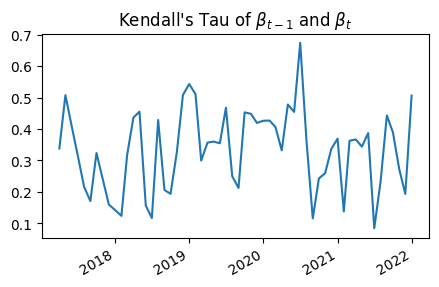

In [65]:
# scrape index constituents using beautifulsoup4 (remove some exceptions below)
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = [row.findAll('td')[0].text for row in table.findAll('tr')[1:]]
tickers = [s.replace('\n', '') for s in tickers] + ["SPY"]
[tickers.remove(i) for i in ["CEG", "BF.B", "BRK.B"]]

# get data via yahoo finance and calculate daily returns
data = yf.download(tickers, start=start_date, end=end_date, progress=False, debug=False)["Adj Close"]
member_returns = data.pct_change().iloc[1:,:].dropna(axis=1)
member_returns.index = pd.DatetimeIndex(member_returns.index)
member_returns.index.name = ""

# calculate rolling 1 month beta using textbook definition: corr * vol ratio
corr = member_returns.groupby(pd.Grouper(freq="M")).apply(lambda x: x.corr().loc["SPY",:]).iloc[1:,:]
std_i = member_returns.groupby(pd.Grouper(freq="M")).std().iloc[1:]
std_bm = member_returns[["SPY"]].groupby(pd.Grouper(freq="M")).std().iloc[1:]
index_beta = corr * (std_i.values / std_bm.values)
index_beta.dropna(inplace=True)

# visualise correlation between beta
corr = [scipy.stats.kendalltau(index_beta.iloc[i-1,:], index_beta.iloc[i,:])[0] for i in range(1, index_beta.shape[0])]
pd.DataFrame(corr, index=index_beta.index[1:]).plot(figsize=(5,3), legend=False, title=r"Kendall's Tau of $\beta_{t-1}$ and $\beta_t$");

In [66]:
results = {}
window = 3
offset = pd.offsets.YearBegin(window)
offset_start = pd.Timestamp(start_date) + offset

for stock in tqdm(member_returns.drop(columns=["SPY"]).columns):
    returns = member_returns[member_returns.index >=  offset_start].loc[:, [stock, "SPY"]]
    results[stock] = {}
    for block in returns.groupby(pd.Grouper(freq="M")):
        # for "simpler" betas the monthly observations suffice
        # for forecast combinations we need more history, here we use 3 years
        date, df = block
        fc_df = returns[(returns.index >= (date - offset)) & (returns.index <= date)]
        
        # set some arbitrary data size threshold ()
        if df.shape[0] > 10 and fc_df.shape[0] > 252:
            exog, endog = df["SPY"], df[stock]
            stock_beta = Beta(exog, endog)
            results[stock][date] = {
                "ols": stock_beta.ols(False),
                "ols_adj": stock_beta.ols(True),
                "vasicek": stock_beta.vasicek(),
                "welch": stock_beta.welch(),
                "ewma": stock_beta.ewma(),
                "dimson": stock_beta.dimson(),
                "welch_aged": stock_beta.welch(rho=2/256),
                "robeco": stock_beta.robeco(0.5, 1.2),
                "scholes_williams": stock_beta.scholes_williams(),
                "forecast_comb": BetaForecastCombination(fc_df["SPY"], fc_df[stock]).fit(),
                "bayesian_ma": BetaBMA(fc_df["SPY"], fc_df[stock]).fit()
            }
     
beta_results = stack_dict_to_df(results)

100%|██████████| 488/488 [1:56:43<00:00, 14.35s/it]  


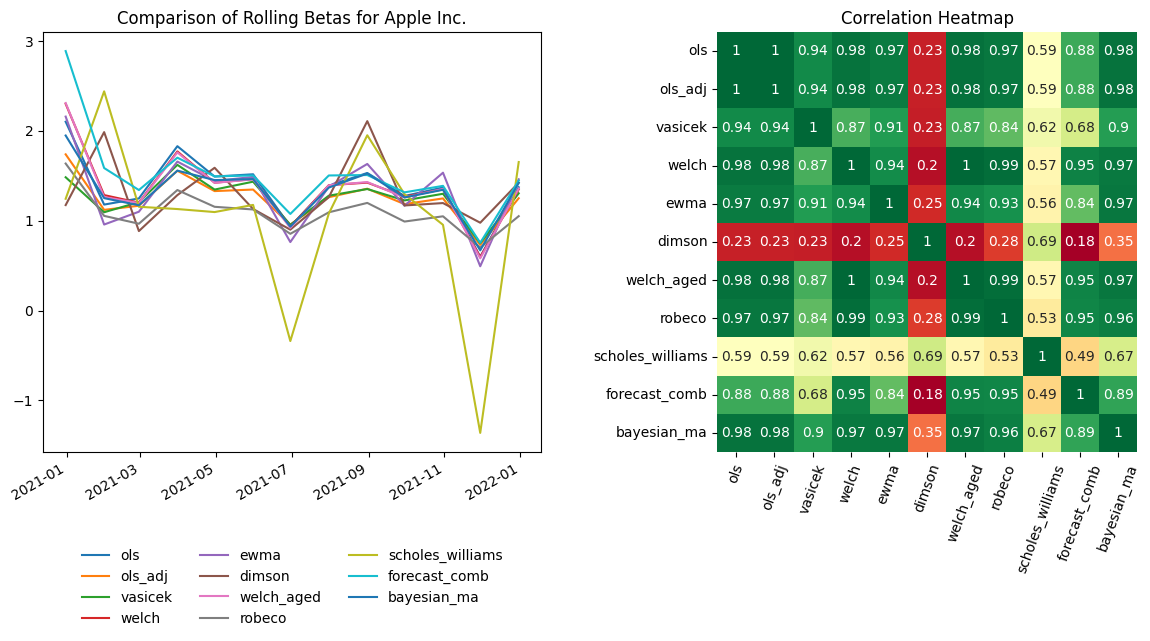

In [112]:
data = beta_results["AAPL"].rename(columns={"forecast_combination": "forecast_comb"})

fig, ax = plt.subplots(ncols=2, figsize=(12,6))
data.plot(title="Comparison of Rolling Betas for Apple Inc.", ax=ax[0])
box = ax[0].get_position()
ax[0].set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, frameon=False)
hm = sns.heatmap(data.corr(), cmap='RdYlGn', ax=ax[1], annot=True, cbar=False, square=True)
hm.set_xticklabels(hm.get_xticklabels(), rotation=70)
ax[1].set_title("Correlation Heatmap")
fig.tight_layout();

## Performance

We use the RMSE as a mean to compare the performance of individual beta estimators to the next month realised beta.

From this small study it appears that on a median basis, the Robeco and Vasicek model have fared the best. As was already obvious from the Apple example, the results for Scholes-Williams are pretty terrible. Possibly an implementation error from my side? In terms of the more complex models, BMA fares better than Forecast Combination. Interesting enough, the simple adjusted OLS model actually gives fairly decent results.

Do note however that this is a *small* subset of data history available. Since the computational effort is quite large for BMA (actually we run $2^k$ model combinations), I've kept it to a short time history.

In [98]:
rms_errors = {}

for stock in results:
    rms_errors[stock] = {}
    beta_lag = beta_results[stock].shift(1).dropna()
    beta_lead = index_beta[[stock]]
    
    for model in beta_lag.columns:
        rmse = np.sqrt(np.square(beta_lag[[model]].join(beta_lead).diff(axis=1).iloc[:,-1]).mean())
        rms_errors[stock][model] = rmse
        
rmse_df = pd.DataFrame.from_dict(rms_errors).T
rmse_df.describe().iloc[[1,4,5,6],:].style.format(precision=2).background_gradient("RdYlGn_r", axis=None)

,ols,ols_adj,vasicek,welch,ewma,dimson,welch_aged,robeco,scholes_williams,forecast_comb,bayesian_ma
mean,0.63,0.55,0.54,0.58,0.67,0.80,0.58,0.53,1.72,0.69,0.56
25%,0.44,0.39,0.40,0.43,0.49,0.56,0.43,0.39,1.00,0.47,0.41
50%,0.58,0.51,0.50,0.55,0.62,0.73,0.54,0.49,1.43,0.61,0.53
75%,0.75,0.65,0.62,0.68,0.80,0.94,0.69,0.62,2.14,0.82,0.67


## Hedging

Another way to assess the performance of our pool of beta estimators is to calculate beta hedged portfolios. For each stock we calculate the returns $r_{bh}=r_i - \beta_k r_m$ and then analyse the overall market exposure. If an estimator is good, the overall market exposure from one period to the next should be very low (ideally close to zero).

In [71]:
# do some pandas acrobatics to get the data in the right shape
filtered_returns = member_returns[beta_results.columns.get_level_values(0).unique()]
repeated_returns = pd.concat([filtered_returns] * rmse_df.shape[1], axis=1).sort_index(axis=1).T
repeated_returns.index.name = "stock"
repeated_returns["metric"] = np.tile(rmse_df.columns, filtered_returns.shape[1])
repeated_returns = repeated_returns.reset_index().set_index(["stock","metric"]).T
repeated_returns.index = pd.to_datetime(repeated_returns.index)
daily_beta = beta_results.reindex(repeated_returns.index).ffill()
market_returns = member_returns[["SPY"]].values

# calculate hedged portfolios
hedged_portfolios = repeated_returns - daily_beta * market_returns
hedged_portfolios.dropna(inplace=True)

# calculate hedge results
hedge_results = {}
for stock in member_returns.drop(columns=["SPY"]).columns:
    hedge_results[stock] = {}
    for beta in rmse_df.columns:
        one = np.ones((hedged_portfolios.shape[0], 1))
        X = np.hstack([one, member_returns.loc[hedged_portfolios.index, ["SPY"]]])
        y = hedged_portfolios.loc[:, (stock, beta)] 
        b = np.linalg.pinv(X) @ y
        rho = b[1] * np.std(X[:,1]) / np.std(y)
        hedge_results[stock][beta] = {
            "b": b[1],
            "rho": rho,
            "r_squared": rho**2
        }

hedge_df = pd.concat({k: pd.DataFrame(v) for k, v in hedge_results.items()})

As can be seen on the distribution plots of the market betas of our beta-hedged portfolios, they generally centre around the zero point. Some beta measures have much wider tails than others. On average the exposure is even slightly negative, meaning we have overhedged. Interestingly, the more complex methods including Forecast Combination and Bayesian Model Averaging perform worse than simpler estimators such as Welch or even Vasicek.

Looking at $R^2$ gives us a similar picture: all estimators have median $R^2$ values close to zero but the tails can very. For example, Scholes-Williams has a much higher hedge-error than e.g. adjusted OLS.

Perhaps one final way to analyse the performance of our estimators could be following Hollstein, Prokopczuk and Wese Simen (2019). The authors create long-short quintile portfolios for Size (SMB), Value (HML), Momentum (WML), Idiosyncratic Vol (residual vol of FF3), Leverage and Illiquidity. Then, they hedge the Q1-Q5 portfolios by solving $υ_{j,t}β^{long}_{j,t}-β^{short}_{j,t}=0$, adjusting the weight factor $υ$ on the long side of the portfolio. They then calculate the 6 month ahead realised beta of each of the portfolios for each beta measure.

Replicating this is not difficult but would require access to point-in-time equity fundamental data, which I do not have access to.

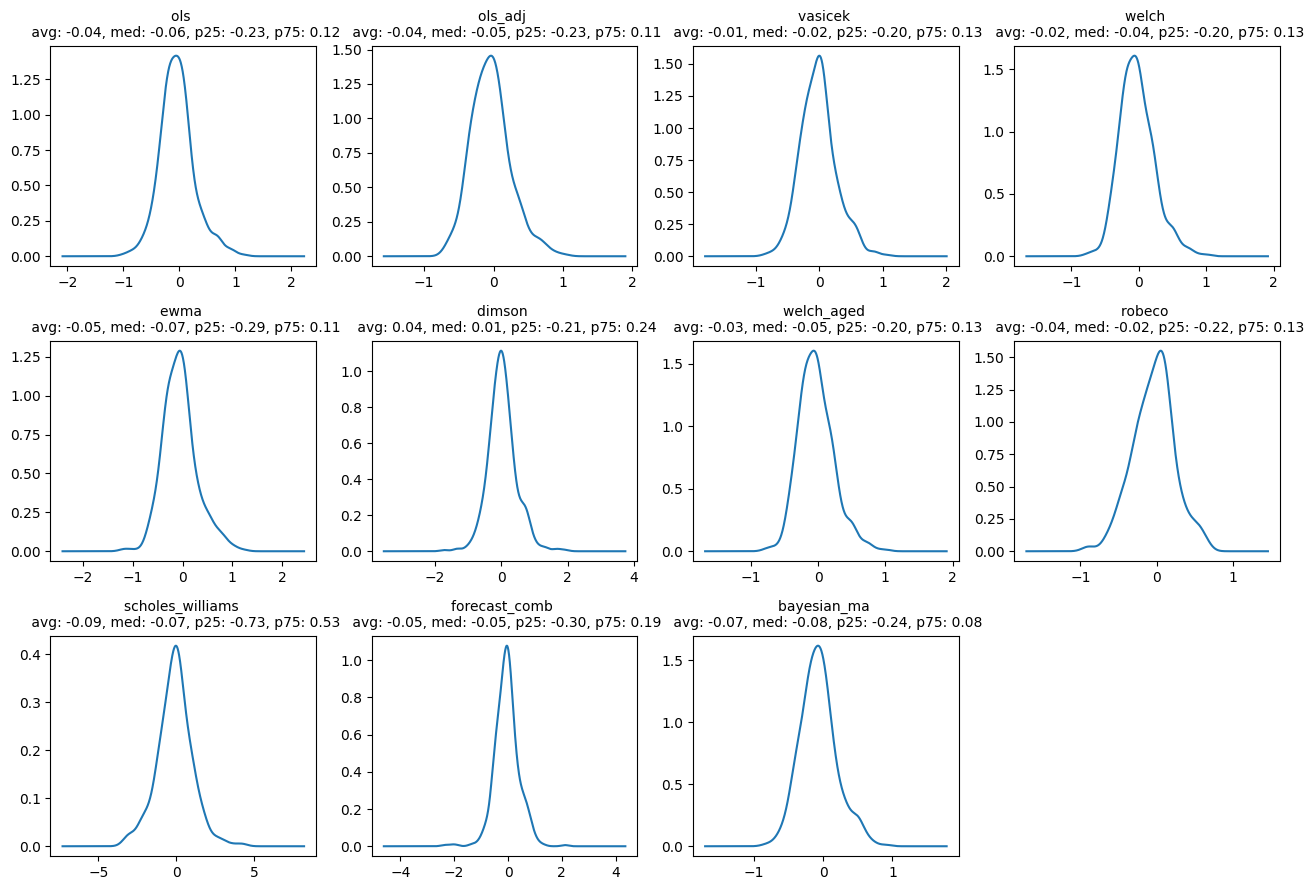

In [102]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(13,9))
c = 0
for i in range(3):
    for j in range(4):
        if c == 11:
            break
        metric = rmse_df.columns[c]
        data = hedge_df.unstack()[metric][["b"]]
        title = "{} \n avg: {:.2f}, med: {:.2f}, p25: {:.2f}, p75: {:.2f}".format(
            metric, data.mean()[0], data.median()[0], data.quantile(0.25)[0], data.quantile(0.75)[0]
        )
        data.plot(kind='density', ax=ax[i,j], title=title, legend=False)
        ax[i,j].title.set_size(10)
        ax[i,j].set_ylabel('')
        c += 1
        
fig.delaxes(ax[-1,-1])
fig.tight_layout()

## A State Space Framework

State space modelling offers an alternative approach to estimating betas at multiple time steps. One can use the [`statsmodels`](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_custom_models.html#Model-1:-time-varying-coefficients) package to express the estimation problem as a function of a latent state vector.

This allows powerful insights into the dynamics of linear systems and deals with the issue of the window parameter choice in rolling regressions quite nicely. The state space model can be written as follows and solved using a Kalman filter (via MLE):

$$y_t = \beta_{x,t} x_t + \epsilon_t$$
$$\beta_{x,t}=\beta_{x,t-1}+\xi_{x,t}$$

where $\epsilon_t \sim N(0,\sigma^2_{\epsilon})$ and $\xi_{x,t}\sim N(0,\sigma^2_{\xi})$. The intuition behind this is that $\beta$ is a function of time, or rather its own history plus a disturbance term.

## References
- Bates, J. M., and C. W. J. Granger. ‘The Combination of Forecasts’. OR 20, no. 4 (1969): 451–68. https://doi.org/10.2307/3008764.
- Blitz, David, Laurens Swinkels, Kristina Ūsaitė, and Pim van Vliet. ‘Shrinking Beta’. SSRN Scholarly Paper. Rochester, NY, 10 February 2022. https://doi.org/10.2139/ssrn.4031825.
- Blume, Marshall E. ‘Betas and Their Regression Tendencies’. The Journal of Finance 30, no. 3 (1975): 785–95. https://doi.org/10.1111/j.1540-6261.1975.tb01850.x.
- Diebold, Francis, and Peter Pauly. ‘The Use of Prior Information in Forecast Combination’. International Journal of Forecasting 6, no. 4 (1990): 503–8.
- Dimson, Elroy. ‘Risk Measurement When Shares Are Subject to Infrequent Trading’. Journal of Financial Economics 7, no. 2 (1 June 1979): 197–226. https://doi.org/10.1016/0304-405X(79)90013-8.
- Frazzini, Andrea, and Lasse Heje Pedersen. ‘Betting against Beta’. Journal of Financial Economics 111, no. 1 (1 January 2014): 1–25. https://doi.org/10.1016/j.jfineco.2013.10.005.
- Hollstein, Fabian, Marcel Prokopczuk, and Chardin Wese Simen. ‘Estimating Beta: Forecast Adjustments and the Impact of Stock Characteristics for a Broad Cross-Section’. SSRN Scholarly Paper. Rochester, NY, 17 August 2018. https://doi.org/10.2139/ssrn.3069518.
- Scholes, Myron, and Joseph Williams. ‘Estimating Betas from Nonsynchronous Data’. Journal of Financial Economics 5, no. 3 (1 December 1977): 309–27. https://doi.org/10.1016/0304-405X(77)90041-1.
- Vasicek, Oldrich A. ‘A Note on Using Cross-Sectional Information in Bayesian Estimation of Security Betas’. The Journal of Finance 28, no. 5 (1973): 1233–39. https://doi.org/10.1111/j.1540-6261.1973.tb01452.x.
- Welch, Ivo. ‘Simply Better Market Betas’. SSRN Scholarly Paper. Rochester, NY, 13 June 2021. https://doi.org/10.2139/ssrn.3371240.
